Maximum likelihood estimates:
d9*eb**9 is -11.76954


  0%|                                                                                                                                | 0/5000 [00:00<?, ?it/s]/cita/modules/python/3.10.2/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1498.75it/s]

(10432, 1)


<IPython.core.display.Math object>

Maximum likelihood estimates:
d9*eb**9 is -5.50134


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 543.67it/s]

(10432, 1)


<IPython.core.display.Math object>

Maximum likelihood estimates:
d9*eb**9 is -2.59591


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 555.65it/s]

(10432, 1)


<IPython.core.display.Math object>

Maximum likelihood estimates:
d9*eb**9 is -1.63111


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 559.45it/s]

(10432, 1)


<IPython.core.display.Math object>

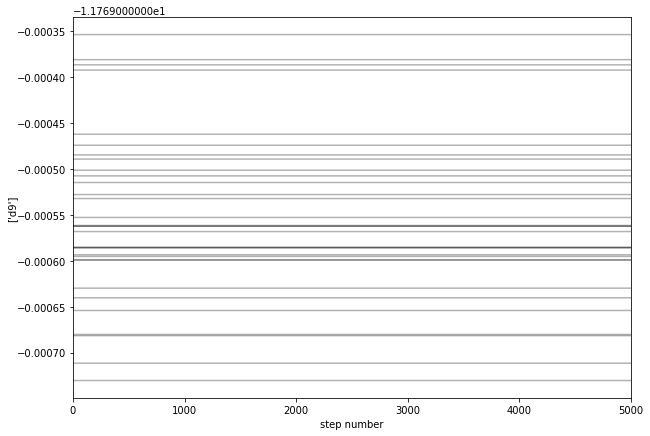

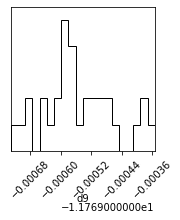

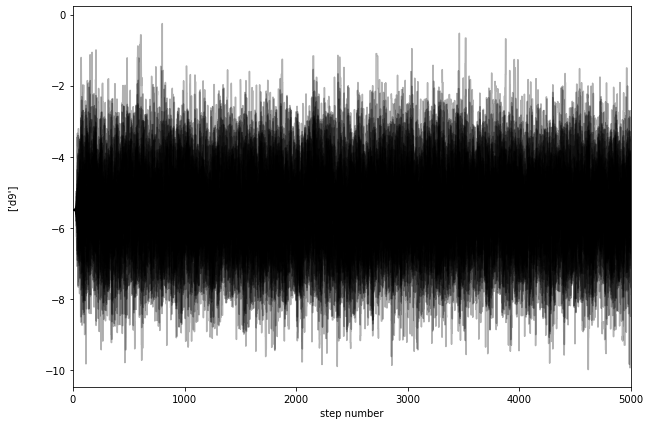

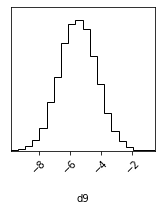

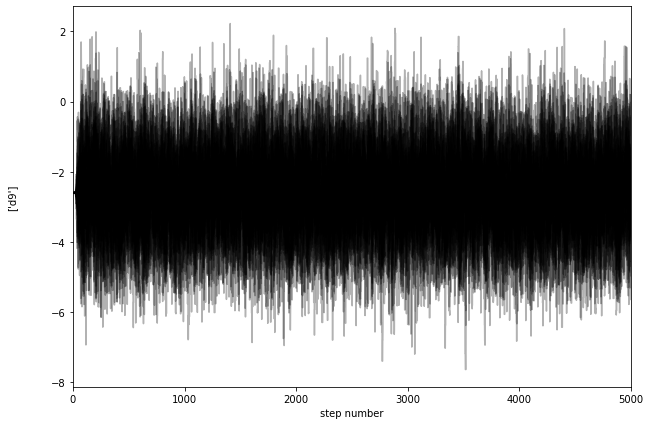

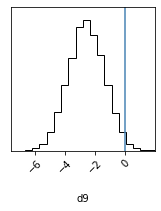

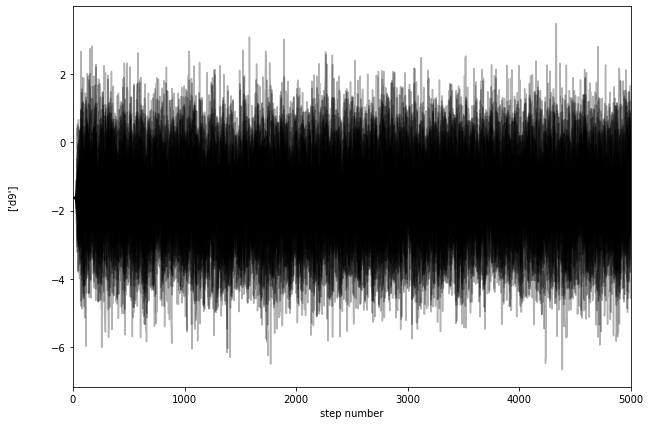

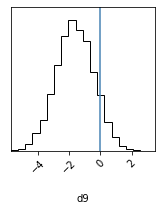

In [1]:
#d9 ONLY emcee ONLY 

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from myfunctions import Lambda_KaplanMeierEstimate as L_KME
from myfunctions import p_expit_emcee as p_ex_em
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit



Ne,Na = 50,50
ebs = np.linspace(0.0,0.8,Ne)
aps = np.linspace(1.0,5.0,Na)
Q_list = [1e1,1e2,1e3,1e4,np.inf]
# Q_num = [1,2,3,4]
# print(aps)

end_time = 62831
# print(Q_num)

# From emcee (H&W Kanah.ipynb)
c0,c1,c2 = 2.347,3.059,-1.386

# fig,axs = plt.subplots(4,1, figsize = (14,14), sharex = True, sharey = True)


for k, Q in enumerate(Q_list[0:4]):
    eb_x = []
    ap_y = []
    for i, eb in enumerate(ebs):
        for j, ap in enumerate(aps):
            filename = f'/mnt/raid-cita/ksmith/cste_Q{k+1}/raw_surv_time_Q{Q:.1f}_eb{eb:.3f}_ap{ap:0.3f}.npy'
            try:
                stime = np.load(filename)
            except:
                stime = np.loadtxt(filename)
#                 print(stime)
            if all(stime > end_time):
                eb_x.append(eb)
                ap_y.append(ap)
                break
#     print(eb_x,ap_y)
#     plt.plot(eb_x, ap_y, label = 'Q: {}'.format(Q))

    
    #Finding d9 using EMCEE
    eb_x = np.asarray(eb_x)
    #x = eb val, y = ap val
    def log_likelihood(theta, x, y):
        d9 = theta
        model = c0 + c1*x + c2*x**2 +d9*x**9
        sigma2 = 0.08
        return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

    def log_prior(theta):
        d9 = theta
        if -10.0 < d9 < 10.0:
            return 0.0
        return -np.inf


    def log_probability(theta, x, y):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, x, y)

    from scipy.optimize import minimize
    np.random.seed(42)
    nll = lambda *args: -log_likelihood(*args)


    initial = np.array([-1.0]) 
    soln = minimize(nll, initial, args=(eb_x, ap_y))

    d9 = soln.x

    print("Maximum likelihood estimates:")
    print("d9*eb**9 is {0:.5f}".format(d9[0]))

    #************
    import emcee
    pos = soln.x + 1e-4 * np.random.randn(32, 1)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(eb_x, ap_y)
    )
    sampler.run_mcmc(pos, 5000, progress=True);
    
    #*************
    fig, axes = plt.subplots(1,1, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ["d9"]

    ndim = 1
    for i in range(ndim):
        ax = axes
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels)
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes.set_xlabel("step number");

    #************
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    print(flat_samples.shape)

    import corner
    fig = corner.corner(
        flat_samples, labels=labels, truths=['d9']
    );
    
    
    #*********
    from IPython.display import display, Math
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))




    




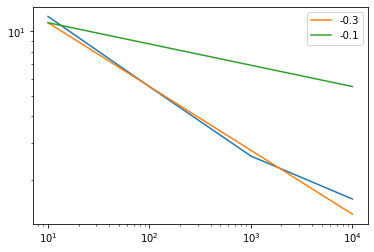

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot([10,100,1000,10000],[11.77,5.501,2.596,1.631])
Q_list = [1e1,1e2,1e3,1e4,np.inf]

for i in [-0.3,-0.1]:
#     print([Q**i for Q in Q_list[0:4]])
    plt.plot(Q_list[0:4],[((Q**i)/10**i)*11 for Q in Q_list[0:4]],label = i)
                          
plt.xscale('log')
plt.yscale('log')
plt.legend()

[1.         1.08163265 1.16326531 1.24489796 1.32653061 1.40816327
 1.48979592 1.57142857 1.65306122 1.73469388 1.81632653 1.89795918
 1.97959184 2.06122449 2.14285714 2.2244898  2.30612245 2.3877551
 2.46938776 2.55102041 2.63265306 2.71428571 2.79591837 2.87755102
 2.95918367 3.04081633 3.12244898 3.20408163 3.28571429 3.36734694
 3.44897959 3.53061224 3.6122449  3.69387755 3.7755102  3.85714286
 3.93877551 4.02040816 4.10204082 4.18367347 4.26530612 4.34693878
 4.42857143 4.51020408 4.59183673 4.67346939 4.75510204 4.83673469
 4.91836735 5.        ]
Maximum likelihood estimates:
d9*eb**9 is -1.43039
alpha is -0.91530


  0%|                                                                                                                                | 0/5000 [00:00<?, ?it/s]/cita/modules/python/3.10.2/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1457.16it/s]


(10432, 2)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Maximum likelihood estimates:
d9*eb**9 is -1.08872
alpha is -0.35178


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 641.11it/s]


(10432, 2)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Maximum likelihood estimates:
d9*eb**9 is -1.00329
alpha is -0.13762


  0%|                                                                                                                                | 0/5000 [00:00<?, ?it/s]/cita/modules/python/3.10.2/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1429.86it/s]


(10432, 2)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Maximum likelihood estimates:
d9*eb**9 is -1.00419
alpha is -0.05267


  0%|                                                                                                                                | 0/5000 [00:00<?, ?it/s]/cita/modules/python/3.10.2/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1414.04it/s]


(10432, 2)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

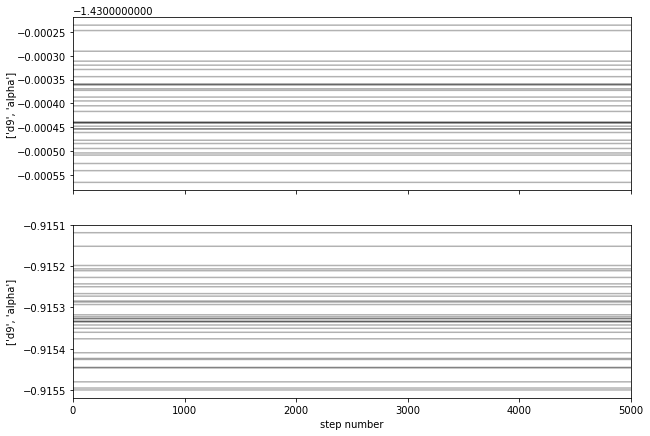

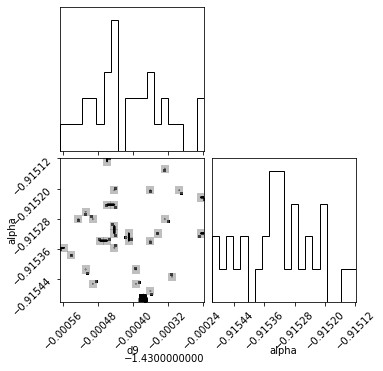

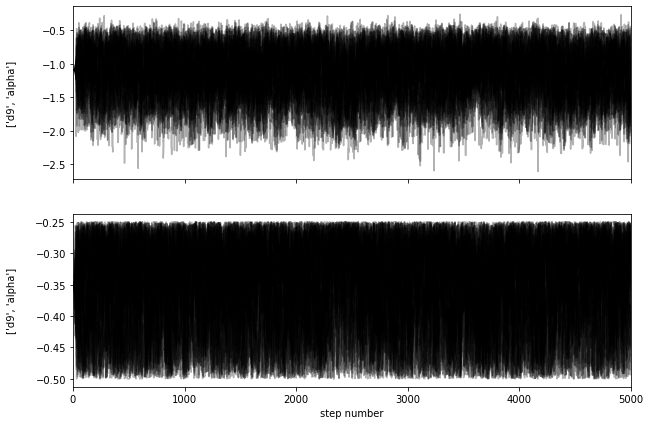

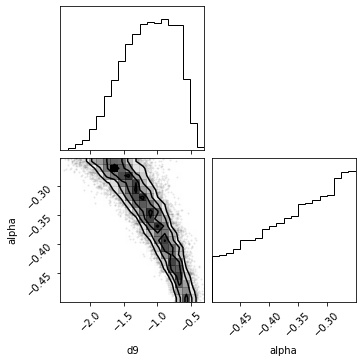

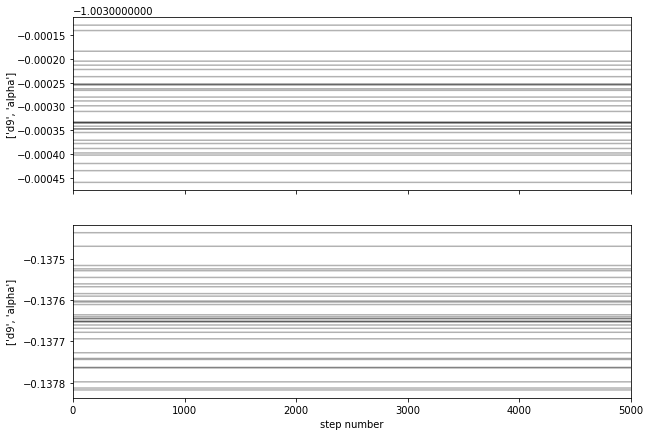

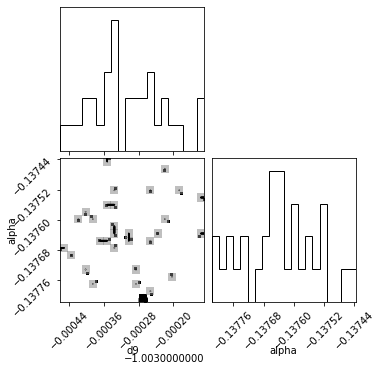

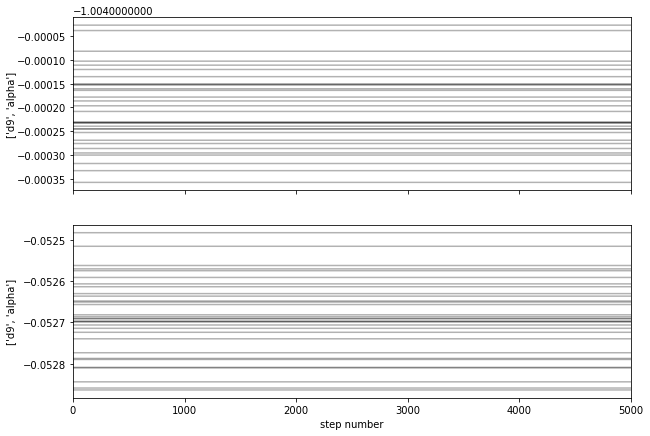

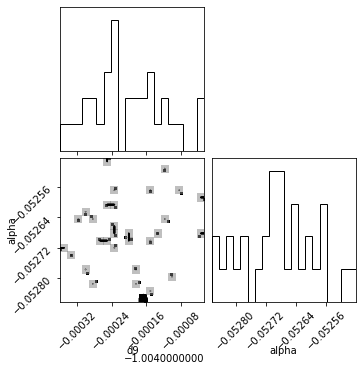

In [3]:
#(1) 2D emcee d9
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from myfunctions import Lambda_KaplanMeierEstimate as L_KME
from myfunctions import p_expit_emcee as p_ex_em
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit

Ne,Na = 50,50
ebs = np.linspace(0.0,0.8,Ne)
aps = np.linspace(1.0,5.0,Na)
Q_list = [1e1,1e2,1e3,1e4,np.inf]
# Q_num = [1,2,3,4]
print(aps)

end_time = 62831
# print(Q_num)

# From emcee (H&W Kanah.ipynb)
c0,c1,c2 = 2.347,3.059,-1.386

# fig,axs = plt.subplots(4,1, figsize = (14,14), sharex = True, sharey = True)

for k, Q in enumerate(Q_list[0:4]):
    eb_x = []
    ap_y = []
    for i, eb in enumerate(ebs):
        for j, ap in enumerate(aps):
            filename = f'/mnt/raid-cita/ksmith/cste_Q{k+1}/raw_surv_time_Q{Q:.1f}_eb{eb:.3f}_ap{ap:0.3f}.npy'
            try:
                stime = np.load(filename)
            except:
                stime = np.loadtxt(filename)
#                 print(stime)
            if all(stime > end_time):
                eb_x.append(eb)
                ap_y.append(ap)
                break
#     print(eb_x,ap_y)
#     plt.plot(eb_x, ap_y, label = 'Q: {}'.format(Q))
    
    #Finding d9 using EMCEE
    eb_x = np.asarray(eb_x)
#     Q_list = [1e1,1e2,1e3,1e4]
#     Q_x = np.asarray(Q_list)
    #x = eb val, Q val, y = ap val
    def log_likelihood(theta, x, y, Q):
        d9,alpha = theta
        model = c0 + c1*x + c2*x**2 +d9*Q**(-alpha)*x**9
        sigma2 = 0.04
        return -0.5 * np.sum((y - model) ** 2 / sigma2)

    def log_prior(theta):
        d9, alpha = theta
        if -10.0 < d9 < 10.0 and -0.5 < alpha < -0.25:
            return 0.0
        return -np.inf

    def log_probability(theta, x, y, Q):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, x, y, Q)

    from scipy.optimize import minimize
    np.random.seed(42)
    nll = lambda *args: -log_likelihood(*args)


    initial = np.array([-1.0,-0.01]) 
    soln = minimize(nll, initial, args=(eb_x, ap_y, Q))

    d9, alpha = soln.x

    print("Maximum likelihood estimates:")
    print("d9*eb**9 is {0:.5f}".format(d9))
    print("alpha is {0:.5f}".format(alpha))


    #************
    import emcee
    nwalkers, ndim = 32, 2
    pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(eb_x, ap_y, Q)
    )
    sampler.run_mcmc(pos, 5000, progress=True);
    
    #*************
    fig, axes = plt.subplots(2,1, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ["d9","alpha"]

    ndim = 2
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels)
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

    #************
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    print(flat_samples.shape)

    import corner
    fig = corner.corner(
        flat_samples, labels=labels, truths=['d9','alpha']
    );
    
    
    #*********
    from IPython.display import display, Math
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))


In [4]:
#(3) 2D emcee d9
# Sampling a multi-dimensional Gaussian 

# Survival Time Data
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from myfunctions import Lambda_KaplanMeierEstimate as L_KME
from myfunctions import p_expit_emcee as p_ex_em
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit

Ne,Na = 50,50
ebs = np.linspace(0.0,0.8,Ne)
aps = np.linspace(1.0,5.0,Na)
Q_list = [1e1,1e2,1e3,1e4,np.inf]
# Q_num = [1,2,3,4]
print(aps)

end_time = 62831
# print(Q_num)

# From emcee (H&W Kanah.ipynb)
c0,c1,c2 = 2.347,3.059,-1.386

# fig,axs = plt.subplots(4,1, figsize = (14,14), sharex = True, sharey = True)


for k, Q in enumerate(Q_list[0:4]):
    eb_x = []
    ap_y = []
    for i, eb in enumerate(ebs):
        for j, ap in enumerate(aps):
            filename = f'/mnt/raid-cita/ksmith/cste_Q{k+1}/raw_surv_time_Q{Q:.1f}_eb{eb:.3f}_ap{ap:0.3f}.npy'
            try:
                stime = np.load(filename)
            except:
                stime = np.loadtxt(filename)
#                 print(stime)
            if all(stime > end_time):
                eb_x.append(eb)
                ap_y.append(ap)
                break
#     print(eb_x,ap_y)
#     plt.plot(eb_x, ap_y, label = 'Q: {}'.format(Q))

   
    #Finding d9 & alpha using EMCEE
#     eb_x = np.asarray(eb_x)
#     Q_list = [1e1,1e2,1e3,1e4]
#     Q_x = np.asarray(Q_list)
#     #x = eb val, Q val, y = ap val
#     def log_likelihood(theta, x, y, Q_x):
#         d9,alpha = theta
#         model = c0 + c1*x + c2*x**2 +d9*Q_x**(-alpha)*x**9
#         sigma2 = 0.04
#         return -0.5 * np.sum((y - model) ** 2 / sigma2)

#     def log_prior(theta):
#         d9, alpha = theta
#         if -10.0 < d9 < 10.0 and -0.5 < alpha < -0.25:
#             return 0.0
#         return -np.inf

#     def log_probability(theta, x, y, Q_x):
#         lp = log_prior(theta)
#         if not np.isfinite(lp):
#             return -np.inf
#         return lp + log_likelihood(theta, x, y, Q_x)
    
    #Multidimension Gaussian
    def log_prob(x, mu, cov):
        diff = x - mu
        return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))
    
    ndim = 2

    cov = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim))
    cov = np.triu(cov)
    cov += cov.T - np.diag(cov.diagonal())
    cov = np.dot(cov, cov)
    
    nwalkers = 32
    p0 = np.random.rand(nwalkers, ndim)
    means = np.array([-1.0,-0.3]) 
    
    import emcee

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

    log_prob(p0, means, cov)
    state = sampler.run_mcmc(p0, 100)
    sampler.reset()
    sampler.run_mcmc(state, 5000);
    
    import matplotlib.pyplot as plt

    samples = sampler.get_chain(flat=True)
    plt.hist(samples[:, 0], 100, color="k", histtype="step")
    plt.xlabel(r"$\theta_1$")
    plt.ylabel(r"$p(\theta_1)$")
    plt.gca().set_yticks([]);






[1.         1.08163265 1.16326531 1.24489796 1.32653061 1.40816327
 1.48979592 1.57142857 1.65306122 1.73469388 1.81632653 1.89795918
 1.97959184 2.06122449 2.14285714 2.2244898  2.30612245 2.3877551
 2.46938776 2.55102041 2.63265306 2.71428571 2.79591837 2.87755102
 2.95918367 3.04081633 3.12244898 3.20408163 3.28571429 3.36734694
 3.44897959 3.53061224 3.6122449  3.69387755 3.7755102  3.85714286
 3.93877551 4.02040816 4.10204082 4.18367347 4.26530612 4.34693878
 4.42857143 4.51020408 4.59183673 4.67346939 4.75510204 4.83673469
 4.91836735 5.        ]


ValueError: solve: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m,n)->(m,n) (size 32 is different from 2)